In [104]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# RUN MODELS

### This notebook serves as a one stop shop for our models. Get all evaluation metrics in one place. 

# Import Data

Current Training Data includes SPF survey responses and price for specific items


In [125]:
data = pd.read_csv("../data/TrainingData/fullDataWithItems.csv")#,index_col=0) 
data.head()
data.columns

Index(['YEAR FORECAST MADE', 'QUARTER', 'YEAR BEING FORECAST', 'INDICATOR',
       'FORECASTER ID', 'INDUSTRY', 'Year.ID.ForecastYear.Quarter',
       'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
       'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
       'BIN 11', 'BIN 1 prob', 'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob',
       'BIN 5 prob', 'BIN 6 prob', 'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob',
       'BIN 10 prob', 'BIN 11 prob', 'BIN 1 midpoint', 'BIN 2 midpoint',
       'BIN 3 midpoint', 'BIN 4 midpoint', 'BIN 5 midpoint', 'BIN 6 midpoint',
       'BIN 7 midpoint', 'BIN 8 midpoint', 'BIN 9 midpoint', 'BIN 10 midpoint',
       'BIN 11 midpoint', 'nbin', 'bin_value_sum', 'TDIST', 'actual',
       'ACTUAL_BIN', 'MAX', 'NUM_OF_MAX', 'ACTUAL_CONF', 'HIT', 'pred_average',
       'pred_var', 'banana', 'beef', 'bread', 'chicken', 'coffee', 'eggs',
       'electricity', 'flour', 'iceCream', 'rice', 'unleadedGasoline'],
      dtype='object')


# Train Val Test Split (0.6,0.2,0.2)

## And save as csv (actually do we really need to)

In [126]:
# relevant=data[data["YEAR FORECAST MADE"]>=1984].drop(columns = ['YEAR FORECAST MADE', 'QUARTER', 'INDUSTRY', 'Year.ID.ForecastYear.Quarter',
#        'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
#        'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
#        'BIN 11', 'BIN 1 prob',
#        'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob', 'BIN 5 prob', 'BIN 6 prob',
#        'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob', 'BIN 10 prob', 'BIN 11 prob',
#        'BIN 1 midpoint', 'BIN 2 midpoint', 'BIN 3 midpoint', 'BIN 4 midpoint',
#        'BIN 5 midpoint', 'BIN 6 midpoint', 'BIN 7 midpoint', 'BIN 8 midpoint',
#        'BIN 9 midpoint', 'BIN 10 midpoint', 'BIN 11 midpoint','nbin', 'bin_value_sum', 'TDIST',
#        'ACTUAL_BIN', 'NUM_OF_MAX',"FORECASTER ID"])
# relevant.dropna(inplace=True)

In [136]:
relevant = data[data["YEAR FORECAST MADE"]>=1992][['YEAR BEING FORECAST', 'INDICATOR', 'actual', 'MAX', 'ACTUAL_CONF',
       'HIT', 'pred_average', 'pred_var', 'banana', 'beef', 'bread', 'chicken',
       'coffee', 'eggs', 'electricity', 'flour', 'iceCream', 'rice',
       'unleadedGasoline']]
relevant.dropna(inplace=True)

In [137]:
train,test = train_test_split(relevant,test_size=.2,random_state=42,stratify=relevant["INDICATOR"])

In [138]:
train,val = train_test_split(train,test_size=0.25, random_state=42,stratify = train["INDICATOR"])

In [139]:
# train.to_csv("../data/TrainingData/shuffled_train.csv",index=False)
# test.to_csv("../data/TestData/shuffled_test.csv",index=False)
# val.to_csv("../data/ValidationData/val.csv",index=False)

# Model Creation

Current Regression Models: XGBoost and RandomForestRegressor
Past Regression Models: LinearRegression, KNN,

In [ ]:
train=pd.read_csv("../data/TrainingData/shuffled_train.csv")
test=pd.read_csv("../data/TestData/shuffled_test.csv")
val=pd.read_csv("../data/ValidationData/val.csv")

In [146]:
train

,YEAR BEING FORECAST,INDICATOR,actual,MAX,ACTUAL_CONF,HIT,pred_average,pred_var,banana,beef,bread,chicken,coffee,eggs,electricity,flour,iceCream,rice,unleadedGasoline
322,1993,RealGDP,2.752850,0.4000,0.2000,0.0,3.250000,1.387500,0.458667,1.563000,0.747000,0.875000,2.422000,0.906667,0.088000,0.240667,2.560333,0.527000,1.107667
17506,2015,Core CPI,1.994200,0.1588,0.1508,0.0,2.173895,1.212533,0.602333,3.848000,1.396333,1.529667,5.009000,2.021000,0.136667,0.537000,4.871000,0.743667,3.681667
5081,2008,RealGDP,-0.136580,0.1900,0.0900,0.0,1.860000,4.350400,0.510667,2.298000,1.195333,1.122333,3.384000,1.497667,0.116667,0.351667,3.849667,0.543000,3.014000
30693,2021,RealGDP,0.000000,0.5500,0.0000,0.0,4.050000,0.547500,0.599667,4.184667,1.510333,1.491667,4.641000,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
381,1993,RealGDP,2.752850,0.3500,0.3500,0.5,2.700000,0.760000,0.467000,1.570000,0.749333,0.884333,2.508000,0.937667,0.090667,0.235667,2.482667,0.519333,1.123667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5215,2007,RealGDP,1.876180,0.5000,0.4500,0.0,1.950000,0.347500,0.506667,2.377667,1.210333,1.139000,3.513000,1.653667,0.121333,0.356000,3.872333,0.548000,2.844000
402,1993,RealGDP,2.752850,0.6500,0.6500,1.0,2.800000,0.410000,0.467000,1.570000,0.749333,0.884333,2.508000,0.937667,0.090667,0.235667,2.482667,0.519333,1.123667
30704,2021,RealGDP,0.000000,0.5500,0.0200,0.0,3.430000,0.845100,0.599667,4.184667,1.510333,1.491667,4.641000,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
9700,2010,Core CPI,0.645573,0.7000,0.1500,0.0,0.250000,0.075000,0.577333,2.451000,1.372667,1.270000,3.988667,1.571000,0.132667,0.485333,4.392667,0.738333,2.728333


In [140]:
def MeasureSplit(df,measure):
    return df[df["INDICATOR"]==measure].drop(columns = ["actual","INDICATOR","YEAR BEING FORECAST"]),df[df["INDICATOR"]==measure]["actual"]

In [141]:
class RegressionModel:
    measures = ["Unemployment","RealGDP","Core CPI","Core PCE"]
    
    def __init__(self,name,model):
        self.name = name
        self.model = model
        self.fitted_models = dict.fromkeys(self.measures,None)
        self.rmse_scores = []
        self.optimized_rmse_scores = []
        self.optimized_r2_scores = []
        self.r2_scores = []
        self.validation = True
        self.best_models = dict.fromkeys(self.measures,None)
        self.optimized=False
        self.store_scores()  
    
    def set_validation(setting):
        self.validation=setting
        
    def clear_scores(self):
        self.rmse_scores = []
        self.r2_scores = []
        
    def store_scores(self):
        if self.optimized==True:
            rmse = self.optimized_rmse_scores
            r2 = self.optimized_r2_scores
        else:
            rmse = self.rmse_scores
            r2 = self.r2_scores
        for measure in self.measures:
            if self.validation:
                X_test,y_test = MeasureSplit(val,measure)
            else: 
                X_test,y_test = MeasureSplit(test,measure)
            predictions = self.get_predictions(measure) 
            rmse.append(np.sqrt(np.mean((y_test-predictions)**2)))
            r2.append(r2_score(y_test,predictions))
        return 
    
    def plot_scores(self):
        fig,axes = plt.subplots(2,1,figsize=(10,20))
        for i,score,s in zip([0,1],['RMSE Scores','R^2 Scores'],[self.rmse_scores,self.r2_scores]):
            sns.barplot(x=self.measures,y=s,ax=axes[i])
            axes[i].set_title(score)
            axes[i].set_xlabel("Economic Measures")
            axes[i].set_ylabel("Score")
        return plt.show()
    
    def get_predictions(self,variable_name):
        assert variable_name in self.measures
        #returns predictions for specified measure
        if self.optimized==True:
            model = self.best_models[variable_name]
        elif self.fitted_models[self.measures[3]] == None:
            model = clone(self.model)
        else:
            model = self.fitted_models[variable_name]
        print(model)
        X_train,y_train = MeasureSplit(train,variable_name)
        if self.validation:
            X_test,y_test = MeasureSplit(val,variable_name)
        else: 
            X_test,y_test = MeasureSplit(test,variable_name)
        model.fit(X_train,y_train)
        if self.optimized == False:
            self.fitted_models[variable_name] = model
        return model.predict(X_test)
    
    def create_results(self):
        data = {}
        for measure in self.measures:
            data[measure] = self.get_predictions(measure)
        return pd.DataFrame(dict([ (self.name+" "+k,pd.Series(v)) for k,v in data.items()]))
    
    def annual_performance(self, variable_name, plot=True):
        assert variable_name in self.measures
        preds = self.get_predictions(variable_name)
        actuals = val[val["INDICATOR"]==variable_name]['actual']
        spf_preds = val[val["INDICATOR"]==variable_name]['pred_average']
        years = val[val["INDICATOR"]==variable_name]['YEAR BEING FORECAST']
        frame = pd.DataFrame({"Actual": actuals, "SPF": spf_preds, "Model": preds, "Year": years})
        grouped = frame.groupby("Year").mean()
        if plot == True:
            fig,axs = plt.subplots(1,1,figsize=(25,10))
            plt.title("Historical Model Performance predicting "+variable_name + ". RMSE: "+str(self.rmse_scores[self.measures.index(variable_name)]),size=30)
            plt.plot(grouped['Actual'])
            plt.plot(grouped['SPF'])
            plt.plot(grouped['Model'])
            labels = ["Actual", "SPF", "Model"]
            plt.legend(labels)
            plt.show()
            
        return grouped
    
    def perform_gridsearch(self,parameters):
        
        def find_optimal_model(variable_name):
            X_train,y_train = MeasureSplit(train,variable_name)
            gridsearch = GridSearchCV(estimator=self.model,param_grid = parameters,scoring='neg_root_mean_squared_error',n_jobs=5,cv=5,verbose=True)
            gridsearch.fit(X_train,y_train)
            return gridsearch.best_estimator_
        
        for measure in self.measures:    
            self.best_models[measure]=find_optimal_model(measure)
        self.optimized=True
        return
    
    def get_feature_importance(self,variable_name):
        assert variable_name in self.measures
        X_train,y_train = MeasureSplit(train,variable_name)
        temp_model = self.model.fit(X_train,y_train)
        fig,axs = plt.subplots(1,1,figsize=(25,10))
        sorted_scores = temp_model.feature_importances_.argsort()
        sns.barplot(x=X_train.columns[sorted_scores],y=temp_model.feature_importances_[sorted_scores])
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Feature Importance for "+self.name + " predicting: "+variable_name ,size=30);

In [142]:
rf = RegressionModel("RandomForest", RandomForestRegressor())

RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()


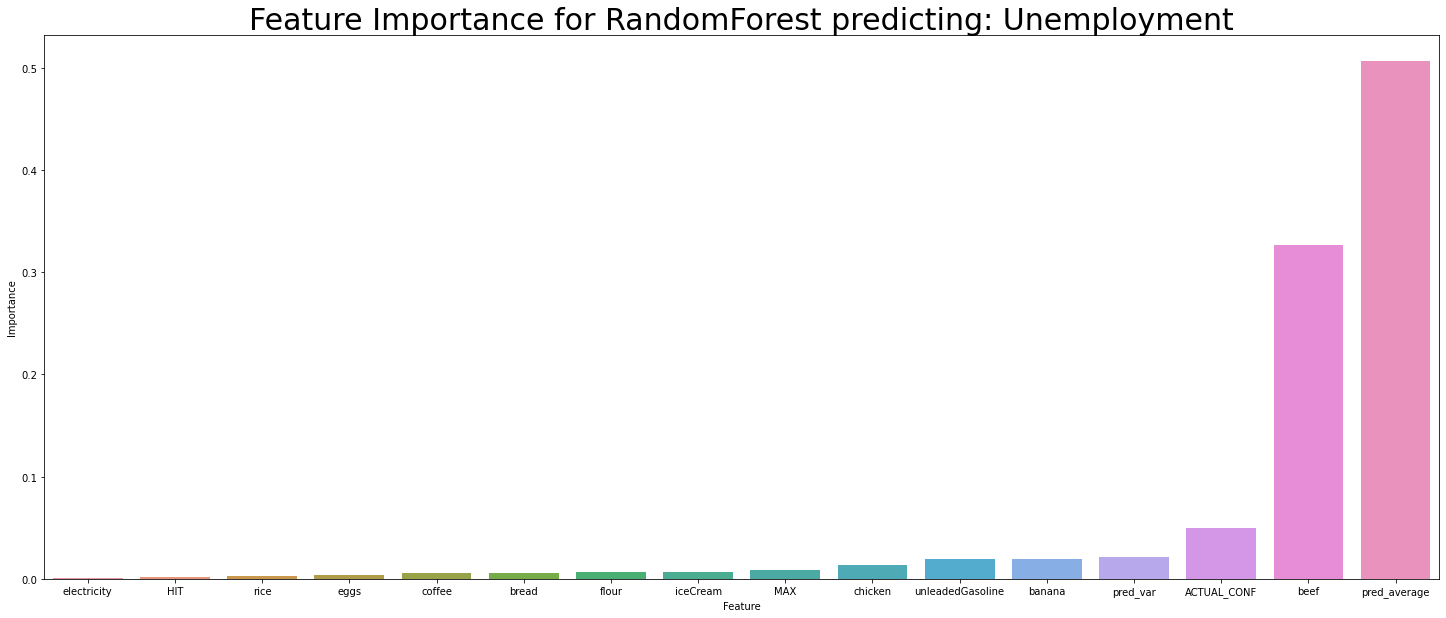

In [143]:
rf.get_feature_importance("Unemployment")

RandomForestRegressor()


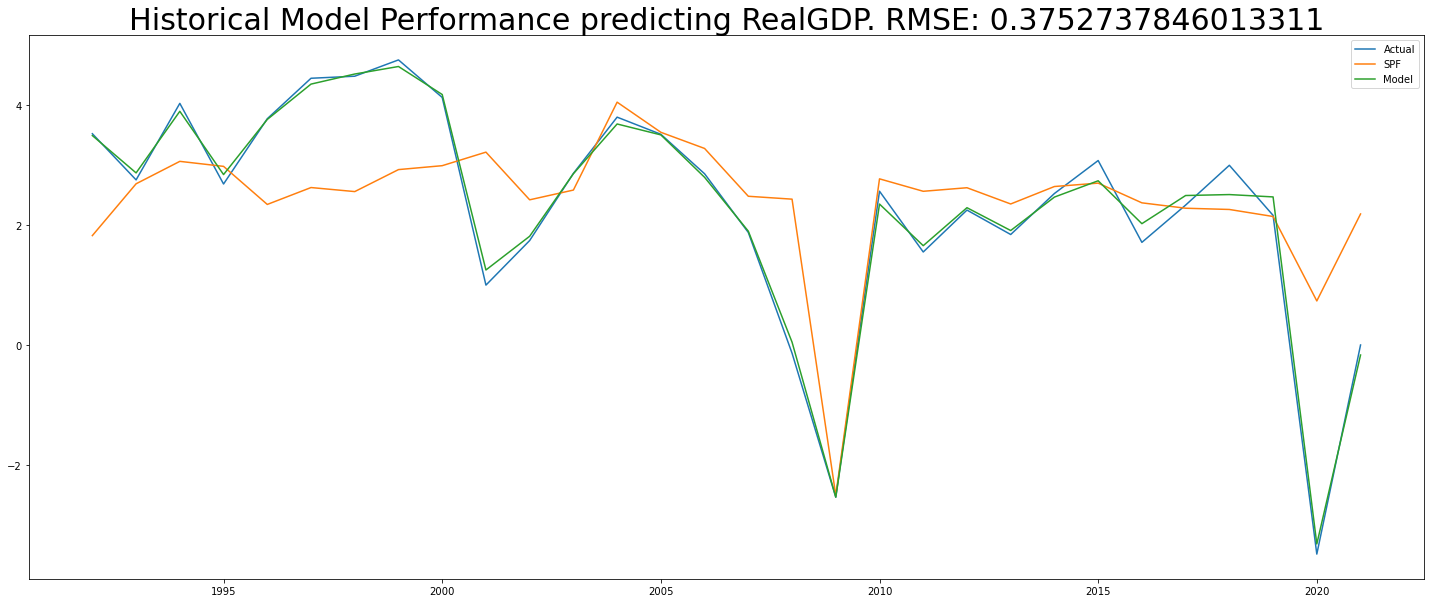

In [144]:
grouped = rf.annual_performance("RealGDP")

In [145]:
grouped

,Actual,SPF,Model
Year,,,
1992,3.52244,1.824083,3.491844
1993,2.75285,2.687703,2.869340
1994,4.02883,3.061755,3.896368
1995,2.68428,2.978286,2.841627
1996,3.77250,2.343547,3.760749
1997,4.44722,2.625180,4.349857
1998,4.48141,2.557842,4.517895
1999,4.75324,2.924400,4.643249
2000,4.12748,2.989625,4.176343


In [122]:
val[val["INDICATOR"]=="RealGDP"]['actual']
val[(val["INDICATOR"]=="RealGDP") &(val['YEAR BEING FORECAST']==2024)]

,YEAR BEING FORECAST,INDICATOR,actual,MAX,ACTUAL_CONF,HIT,pred_average,pred_var,banana,beef,bread,chicken,coffee,eggs,electricity,flour,iceCream,rice,unleadedGasoline
30987,2024,RealGDP,6.3,0.450,0.15,0.0,1.8000,0.610000,0.599667,4.184667,1.510333,1.491667,4.641,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
30981,2024,RealGDP,6.3,0.350,0.15,0.0,1.2500,1.187500,0.599667,4.184667,1.510333,1.491667,4.641,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
30984,2024,RealGDP,6.3,0.370,0.15,0.0,2.0900,1.741900,0.599667,4.184667,1.510333,1.491667,4.641,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
30974,2024,RealGDP,6.3,0.500,0.15,0.0,4.7125,0.526719,0.599667,4.184667,1.510333,1.491667,4.641,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
30549,2024,RealGDP,6.3,0.500,0.20,0.0,1.7500,0.687500,0.593667,3.998000,1.536333,1.573667,4.645,1.562667,0.137000,0.440667,4.966667,0.781667,2.537667
31005,2024,RealGDP,6.3,0.279,0.15,0.0,1.3740,1.488124,0.599667,4.184667,1.510333,1.491667,4.641,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
30980,2024,RealGDP,6.3,0.250,0.15,0.0,2.1000,2.140000,0.599667,4.184667,1.510333,1.491667,4.641,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333
30550,2024,RealGDP,6.3,0.500,0.20,0.0,2.3000,0.760000,0.593667,3.998000,1.536333,1.573667,4.645,1.562667,0.137000,0.440667,4.966667,0.781667,2.537667
30545,2024,RealGDP,6.3,0.320,0.20,0.0,1.6100,1.377900,0.593667,3.998000,1.536333,1.573667,4.645,1.562667,0.137000,0.440667,4.966667,0.781667,2.537667
30994,2024,RealGDP,6.3,0.350,0.15,0.0,1.8500,1.127500,0.599667,4.184667,1.510333,1.491667,4.641,1.629000,0.140333,0.410667,4.849667,0.788000,2.988333


In [123]:
xgboost = RegressionModel("XGBoost", XGBRegressor(verbosity=0))
xg_preds = xgboost.get_predictions("RealGDP")
actuals = val[val["INDICATOR"]=="RealGDP"]["actual"]
spf_preds = val[val["INDICATOR"]=="RealGDP"]["pred_average"]
years = val[val["INDICATOR"]=="RealGDP"]['YEAR BEING FORECAST']
frame = pd.DataFrame({"Actual": actuals, "SPF": spf_preds, "Model": preds, "Year": years})
new = frame.sort_values(by="Year")
grouped = new.groupby("Year").mean()
plt.plot(grouped['Actual'])
plt.plot(grouped['SPF'])
plt.plot(grouped['Model'])
labels = ["Actual", "SPF", "Model"]
plt.legend(labels)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_

NameError: name 'preds' is not defined

In [56]:
X_train, Y_train = MeasureSplit(train, "RealGDP")

In [57]:
X_test, Y_test = MeasureSplit(val, "RealGDP")

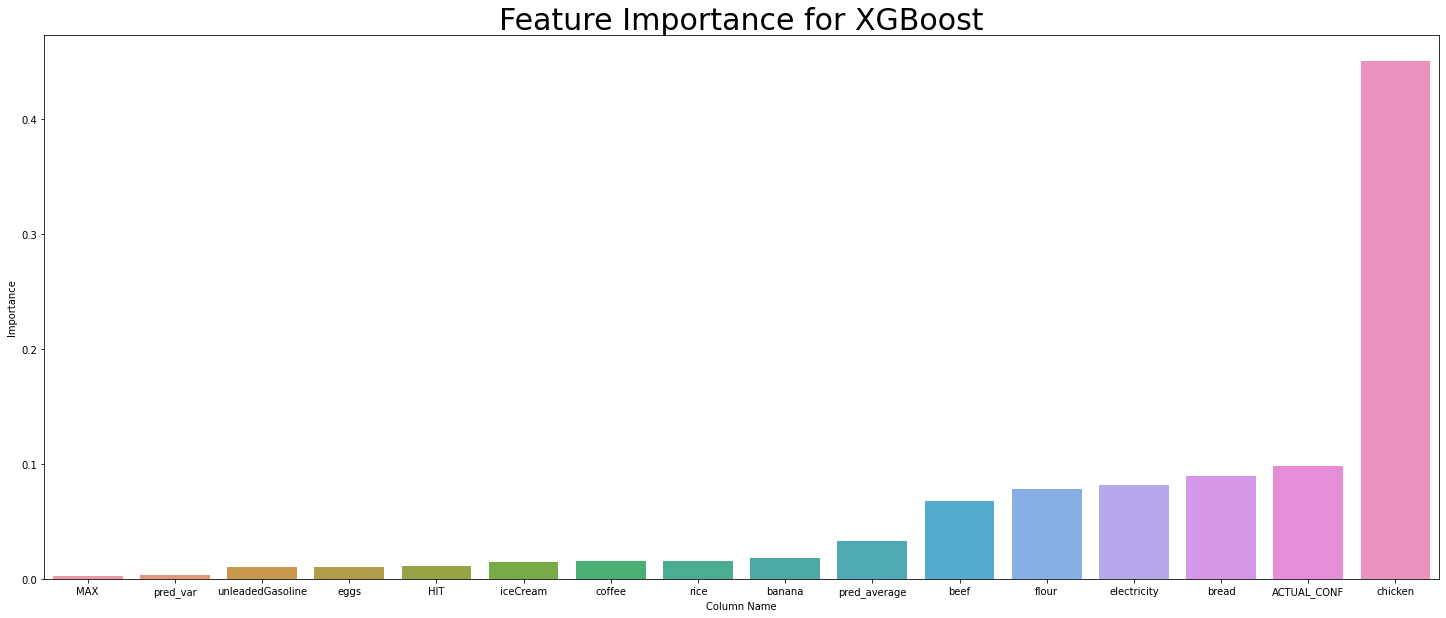

In [62]:
xgb = XGBRegressor(verbosity=0).fit(X_train, Y_train)
fig,axs = plt.subplots(1,1,figsize=(25,10))
sorted_scores = xgb.feature_importances_.argsort()
sns.barplot(x=X_train.columns[sorted_scores],y=xgb.feature_importances_[sorted_scores])
plt.xlabel("Column Name")
plt.ylabel("Importance")
plt.title("Feature Importance for XGBoost",size=30);

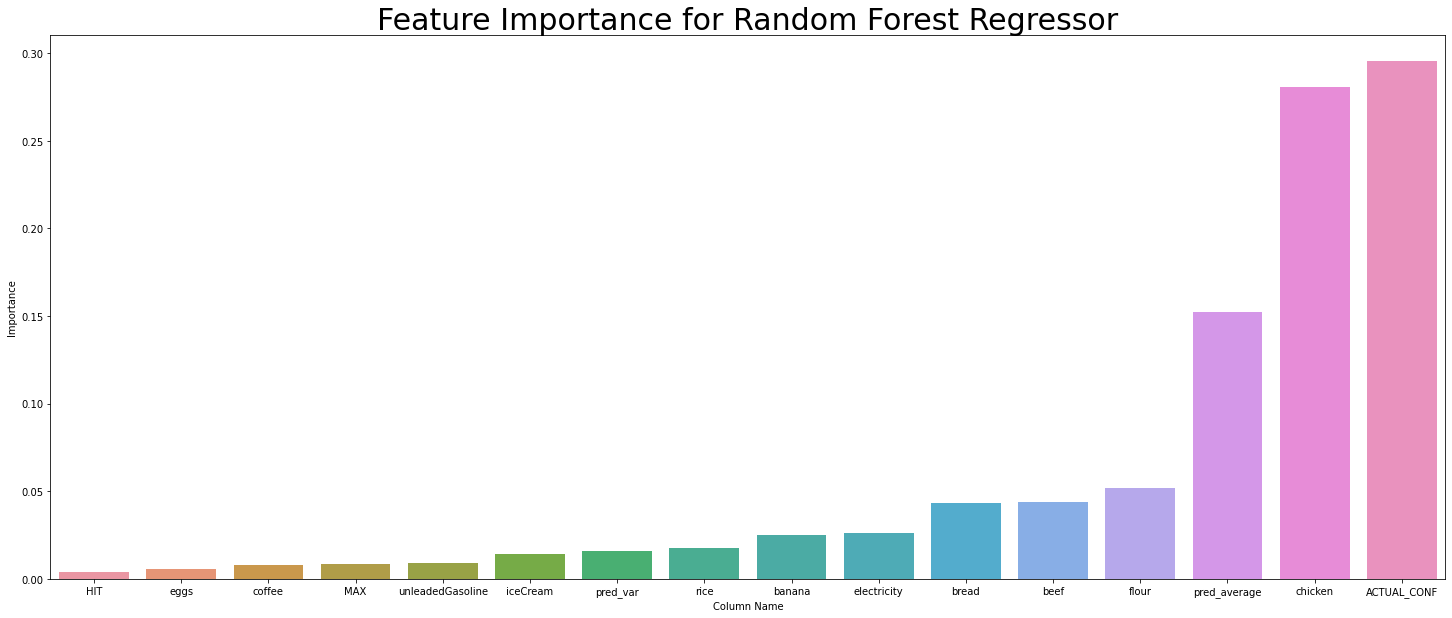

In [60]:
randomforest = RandomForestRegressor().fit(X_train, Y_train)
fig,axs = plt.subplots(1,1,figsize=(25,10))
sorted_scores = randomforest.feature_importances_.argsort()
sns.barplot(x=X_train.columns[sorted_scores],y=randomforest.feature_importances_[sorted_scores])
plt.xlabel("Column Name")
plt.ylabel("Importance")
plt.title("Feature Importance for Random Forest Regressor",size=30);

In [54]:
xgboost.best_models = {'Unemployment': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0),
 'RealGDP': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0),
 'Core CPI': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0),
 'Core PCE': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)}

In [12]:
xgboost_parameters = {'max_depth':np.arange(2,10),'n_estimators': np.arange(60,200,40),"learning_rate":[0.01,0.05,0.1]}

In [13]:
xgboost.perform_gridsearch(xgboost_parameters)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [56]:
xgboost.optimized=True
xgboost.store_scores()

In [57]:
xgboost.rmse_scores

[0.6871500325214561,
 0.43316816574009354,
 0.39824419749116546,
 0.3210065767781438]

In [58]:
xgboost.optimized_rmse_scores

[0.6742677863500751,
 0.42378448833869503,
 0.39885080082601687,
 0.40314091915689343]

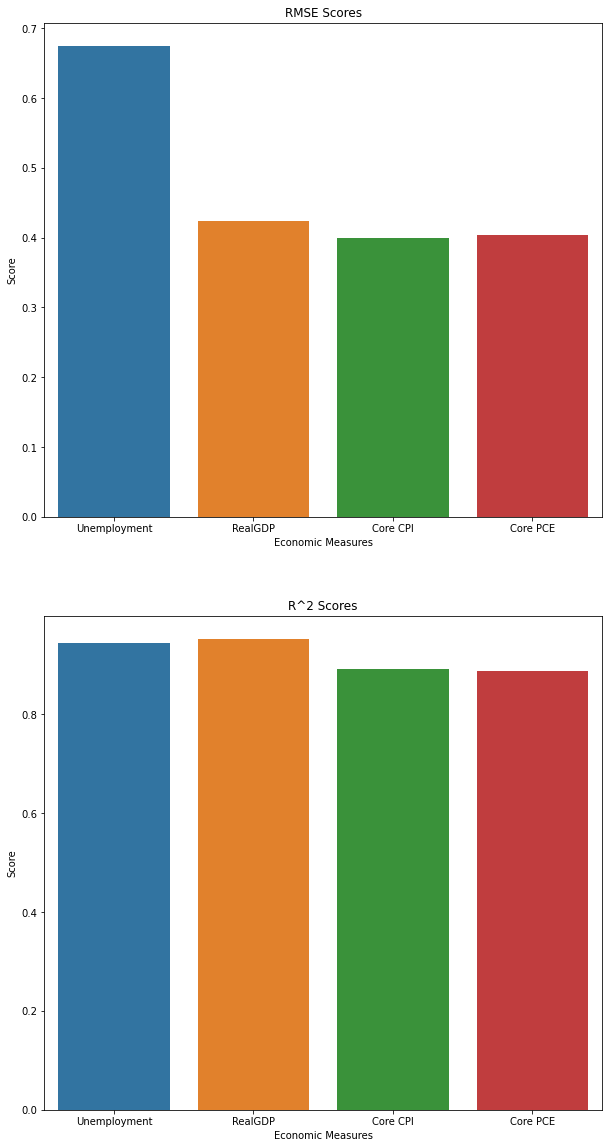

In [37]:
xgboost.plot_scores()

In [65]:
xgboost.optimized

True

In [66]:
xg_scores = xgboost.create_results()

In [59]:
RF = RegressionModel("Random Forest" ,RandomForestRegressor())

In [45]:
RF_params = {"n_estimators":np.arange(100,300,20)}

In [46]:
RF.perform_gridsearch(RF_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [60]:
RF.best_models = {'Unemployment': RandomForestRegressor(n_estimators=180),
 'RealGDP': RandomForestRegressor(n_estimators=160),
 'Core CPI': RandomForestRegressor(),
 'Core PCE': RandomForestRegressor(n_estimators=120)}

In [61]:
RF.best_models

{'Unemployment': RandomForestRegressor(n_estimators=180),
 'RealGDP': RandomForestRegressor(n_estimators=160),
 'Core CPI': RandomForestRegressor(),
 'Core PCE': RandomForestRegressor(n_estimators=120)}

In [62]:
RF.optimized=True
RF.store_scores()

In [63]:
RF.rmse_scores

[0.7065132210519138,
 0.4157836682672575,
 0.34028788176224795,
 0.40485490317099837]

In [64]:
RF.optimized_rmse_scores

[0.7094118600284802,
 0.41713586057771124,
 0.34741118690012224,
 0.3952660596084598]

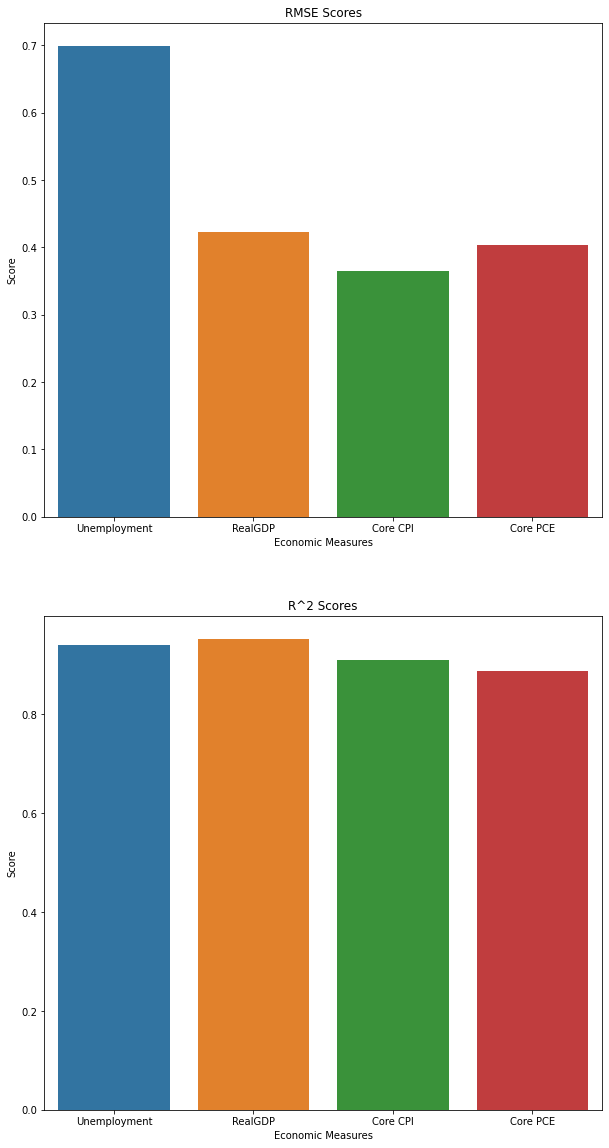

In [43]:
RF.plot_scores()

In [ ]:
RF.get_predictions("Unemployment")

In [67]:
RF.optimized

True

In [68]:
rf_scores = RF.create_results()

In [ ]:
lm  = RegressionModel("Linear Regression", LinearRegression())

In [ ]:
lm_scores = lm.create_results()

In [ ]:
lm.plot_scores()

In [ ]:
neighbors = RegressionModel("KNeigborsRegressor",KNeighborsRegressor())

In [ ]:
neighbors.plot_scores()

In [ ]:
neighbor_scores = neighbors.create_results()

In [69]:
model_predictions = pd.concat([xg_scores,rf_scores],axis=1)#,lm_scores,neighbor_scores],axis=1)

In [70]:
model_predictions

,XGBoost Unemployment,XGBoost RealGDP,XGBoost Core CPI,XGBoost Core PCE,Random Forest Unemployment,Random Forest RealGDP,Random Forest Core CPI,Random Forest Core PCE
0,0.024529,2.525367,2.284678,1.277267,0.000000,2.690666,2.275708,1.246261
1,3.809880,4.161139,2.084491,1.495712,3.874306,4.249021,2.174324,1.351786
2,3.915925,4.266360,2.059632,1.563071,3.712870,4.158768,1.961115,1.640270
3,8.112351,0.977842,2.211206,1.715864,8.108333,0.355206,2.221205,1.722364
4,4.358871,4.604209,2.228309,1.908844,4.350000,4.530313,2.218232,1.703876
...,...,...,...,...,...,...,...,...
2665,NaN,2.695229,NaN,NaN,NaN,2.913138,NaN,NaN
2666,NaN,2.509414,NaN,NaN,NaN,2.639555,NaN,NaN
2667,NaN,4.217857,NaN,NaN,NaN,4.127480,NaN,NaN
2668,NaN,2.411485,NaN,NaN,NaN,2.402891,NaN,NaN


In [71]:
t = val.loc[:,["INDICATOR","actual"]]
initial = pd.DataFrame([])
for measure in xgboost.measures:
    temp = t[t["INDICATOR"]==measure]
    temp.rename(columns={"actual":measure + " actual","INDICATOR":measure},inplace=True)
    temp.reset_index(inplace=True)
    initial = pd.concat([initial,temp],axis=1)
initial.drop(columns = ['index'],inplace=True)


C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [72]:
final = pd.concat([initial,model_predictions],axis=1)

In [73]:
final

,Unemployment,Unemployment actual,RealGDP,RealGDP actual,Core CPI,Core CPI actual,Core PCE,Core PCE actual,XGBoost Unemployment,XGBoost RealGDP,XGBoost Core CPI,XGBoost Core PCE,Random Forest Unemployment,Random Forest RealGDP,Random Forest Core CPI,Random Forest Core PCE
0,Unemployment,0.000000,RealGDP,2.99646,Core CPI,2.290573,Core PCE,1.184167,0.024529,2.525367,2.284678,1.277267,0.000000,2.690666,2.275708,1.246261
1,Unemployment,3.891667,RealGDP,4.44722,Core CPI,2.174324,Core PCE,1.184167,3.809880,4.161139,2.084491,1.495712,3.874306,4.249021,2.174324,1.351786
2,Unemployment,3.683333,RealGDP,4.75324,Core CPI,2.174324,Core PCE,1.647664,3.915925,4.266360,2.059632,1.563071,3.712870,4.158768,1.961115,1.640270
3,Unemployment,8.108333,RealGDP,2.99646,Core CPI,2.290573,Core PCE,1.664742,8.112351,0.977842,2.211206,1.715864,8.108333,0.355206,2.221205,1.722364
4,Unemployment,4.350000,RealGDP,4.75324,Core CPI,2.290573,Core PCE,1.559324,4.358871,4.604209,2.228309,1.908844,4.350000,4.530313,2.218232,1.703876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,NaN,NaN,RealGDP,2.68428,NaN,NaN,NaN,NaN,NaN,2.695229,NaN,NaN,NaN,2.913138,NaN,NaN
2666,NaN,NaN,RealGDP,3.07551,NaN,NaN,NaN,NaN,NaN,2.509414,NaN,NaN,NaN,2.639555,NaN,NaN
2667,NaN,NaN,RealGDP,4.12748,NaN,NaN,NaN,NaN,NaN,4.217857,NaN,NaN,NaN,4.127480,NaN,NaN
2668,NaN,NaN,RealGDP,2.56377,NaN,NaN,NaN,NaN,NaN,2.411485,NaN,NaN,NaN,2.402891,NaN,NaN


In [74]:
final.to_csv("../models/results_post_gridsearch.csv",index=False)